In [64]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 1. Top 500 peak performance in 2025

In [2]:
data = pd.read_excel("TOP500_202206.xlsx")

In [4]:
data.columns

Index(['Rank', 'Previous Rank', 'First Appearance', 'First Rank', 'Name',
       'Computer', 'Site', 'Manufacturer', 'Country', 'Year', 'Segment',
       'Total Cores', 'Accelerator/Co-Processor Cores', 'Rmax [TFlop/s]',
       'Rpeak [TFlop/s]', 'Nmax', 'Nhalf', 'HPCG [TFlop/s]', 'Power (kW)',
       'Power Source', 'Energy Efficiency [GFlops/Watts]', 'Memory',
       'Architecture', 'Processor', 'Processor Technology',
       'Processor Speed (MHz)', 'Operating System', 'OS Family',
       'Accelerator/Co-Processor', 'Cores per Socket', 'Processor Generation',
       'System Model', 'System Family', 'Interconnect Family', 'Interconnect',
       'Continent', 'Site ID', 'System ID'],
      dtype='object')

В данной подзадаче нас интересуют следующие атрибуты:

In [5]:
performance_attrs = ["Rmax [TFlop/s]", "Rpeak [TFlop/s]"]

In [6]:
performance_data = data[performance_attrs]

In [11]:
performance_data.head()

,Rmax [TFlop/s],Rpeak [TFlop/s]
0,1102000.0,1685651.46
1,442010.0,537212.00
2,151900.0,214351.87
3,148600.0,200794.88
4,94640.0,125712.00


In [13]:
performance_data.shape

(500, 2)

Оказывается, здесь только данные именно по топ-500, а нам же нужен ряд ТОП-1 за каждые пол года с начала ведения рейтинга. Поискав в интернете, нашел график и спарсил его значения:

In [16]:
with open("top500.json", "r") as f:
    top500 = json.load(f)

In [19]:
top1 = {key: val["#1"][0] for key, val in top500.items()}

Посмотрим, как производительность ТОП-1 суперкомпьютера (в GFlop/s) меняется со временем:

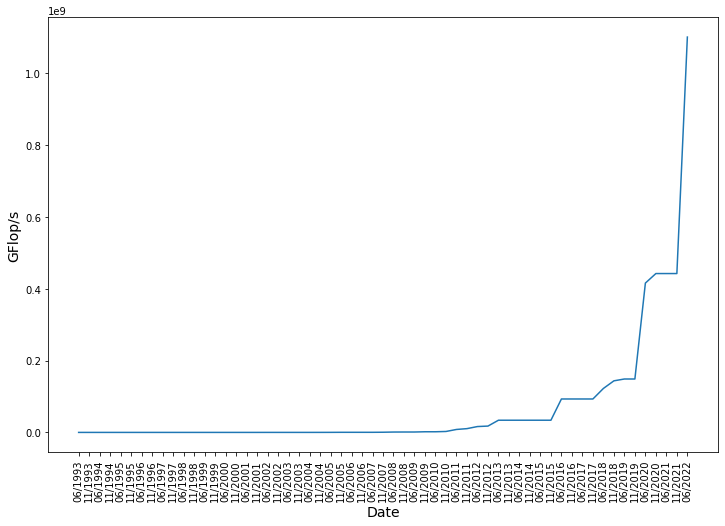

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(top1.keys(), top1.values())
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("GFlop/s", fontsize=14)
plt.xticks(rotation = 90);

В логарифмическом масштабе:

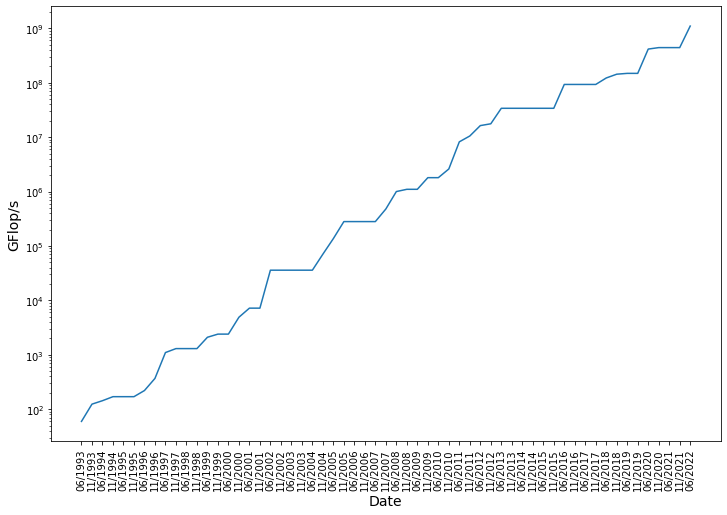

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(top1.keys(), top1.values())
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("GFlop/s", fontsize=14)
plt.xticks(rotation = 90);
plt.yscale("log")

Можно хорошо аппроксимировать линейной регрессией

In [39]:
xs = np.array(list(range(len(top1.keys()))))[:, None]

Таргет (логарифмированный для линейности):

In [66]:
ys = np.log(list(top1.values()))

In [67]:
model = LinearRegression(normalize=True)

In [68]:
model.fit(xs, ys)

LinearRegression(normalize=True)

In [69]:
new_points = {
    59: "11/2022",
    60: "06/2023",
    61: "11/2023",
    62: "06/2024",
    63: "11/2024",
    64: "06/2025",
    65: "11/2025"
}

In [70]:
new_xs = np.array(list(range(len(top1.keys()))) + list(new_points.keys()))[:, None]

Предсказания нужно экспоненцировать, чтобы получить нужные значения (таргет логарифмировали):

In [71]:
predicted_performance = np.exp(model.predict(new_xs))

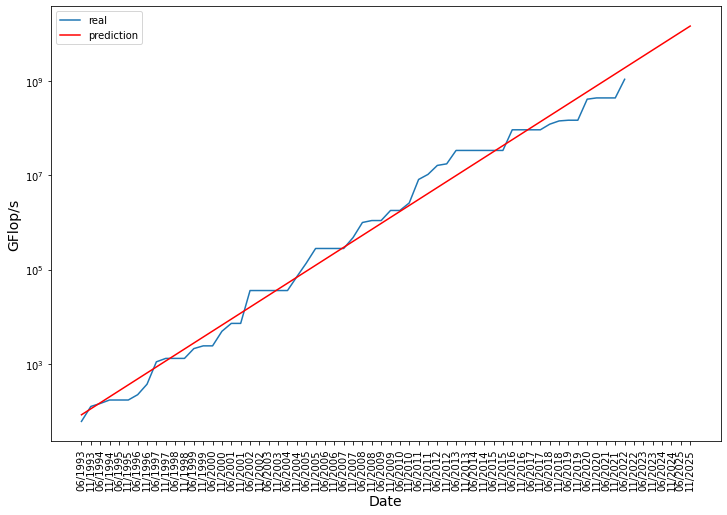

In [74]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(top1.keys(), top1.values(), label="real")
ax.plot(list(top1.keys()) + list(new_points.values()), predicted_performance, color="r", label="prediction")
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("GFlop/s", fontsize=14)
ax.legend()
plt.xticks(rotation = 90);
plt.yscale("log")

То есть в конце 2025 года, если все пойдет также, мы получим следующую производительность (Rmax):

In [78]:
print(f"{predicted_performance[-1]/ 1e9} EFlop/s")

14.838624469265277 EFlop/s


**Ответ:** 14.83 EFlop/s

# 2. Оценка потребляемости электричества суперкомпьютерами из ТОП-500

In [82]:
data["Power (kW)"].dropna()

0      21100.00
1      29899.23
2       2942.13
3      10096.00
4       7438.28
         ...   
472     1050.00
473      524.28
474      807.60
477      260.00
478      558.60
Name: Power (kW), Length: 191, dtype: float64

У нас есть данные не по 500, а только по 191 суперкомпьютеру

Суммарная потребляемая энергия (в кВ):

In [109]:
sum_energy_kW = data["Power (kW)"].dropna().sum()

In [110]:
sum_energy_kW

340486.45

Предположим, что оставшиеся 300 суперкомпьютеров увеличивают эту цифру ~ 2.5 раза

In [111]:
sum_energy_kW *= 2.5

In [112]:
sum_energy_kW

851216.125

Также предположим, что коэффициент загрузки такого оборудования - 0.5 (думается, меньше)

In [113]:
sum_energy_kW *= 0.5

In [114]:
sum_energy_kW

425608.0625

Годовой масштаб:

In [115]:
sum_energy_kW *= (24 * 365)

In [116]:
sum_energy_kW

3728326627.5

[Здесь](https://energystats.enerdata.net/total-energy/world-consumption-statistics.html) можно найти суммарное потребление в Mtoe за 2021 год. Оно ~ 14000 Mtoe, из которых электроэнергии - 10%

Mtoe -> kW

In [117]:
koeff = 11630000000

In [118]:
all_energy_cons = 14000 * 0.1 * koeff

In [119]:
all_energy_cons

16282000000000.0

Тогда можно посчитать % от потребляемого мирового электричества как:

In [120]:
percentage = sum_energy_kW / all_energy_cons * 100
print(f"{percentage}%")

0.022898456132539%


То есть где-то **0.02 процента от всей электроэнергии**. Кажется, оценка занижена, но какая есть.